# Class 8 - Parallelism in Julia

http://mathemathinking.com/uncategorized/parallel-monte-carlo-in-julia/

Today we'll talk a bit about Julia's built-in tecniques for taking advantage of parallelism, as well as Julia's MPI interface and the new parallel linear algebra package that wraps Elemental.

## Example: Monte Carlo Simulations

One of the many ways that computers have aided science is through simulation.  Sometimes you may not have a closed-form way to access a quantity of interest, and can obtain a good guess through running many simulations with parameters drawn from a distribution, and looking at the average behavior of your model.  This class of methods is known as [Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method).  

One of the benefits of Monte Carlo methods is that they are often trivially parallelizable, since you can run independent experiments on separate processes, and then aggregate the results in a single round of communication at the end.

One of the great uses of Monte Carlo methods is [integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration), which becomes increasingly attractive over high-dimensional domains.  The cannonical example is estimating $\pi$ by integrating a circle on a square domian.

The area of a circle with unit radius is $\pi r^2 = \pi$.
The area of a square on $[-1, 1]^2$ is 4.  If we place the unit circle in this square, the ratio of their areas is $\pi/4$.  The idea is that we sample uniformly on this square, and then see what portion of the points lie in the circle.  We know that this ratio should be approximately $\pi/4$, so re multiply the ratio by 4 to obtain our approximation of $\pi$.

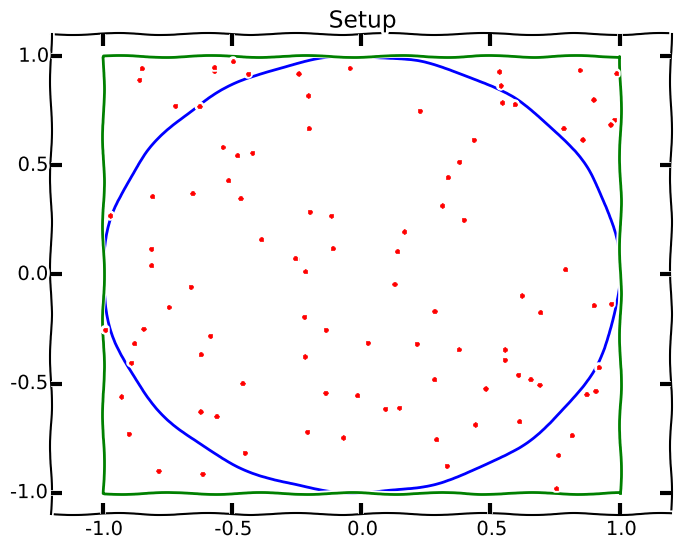

In [74]:
using PyPlot
θ = linspace(0,2π,1000)
circ_xs = cos(θ)
circ_ys = sin(θ)

sq_xs = [ 1, 1,-1,-1, 1]
sq_ys = [-1, 1, 1,-1,-1]

r_xs = rand(100) * 2 - 1
r_ys = rand(100) * 2 - 1

plot(circ_xs,circ_ys, "b-", sq_xs, sq_ys, "g-", r_xs, r_ys, "r.")
axis([-1.2, 1.2, -1.1, 1.1])
xkcd()
title("Setup")
show()
;


In [32]:
function π_monte_carlo(n_samples::Int64)
    n_circle = 0
    for i=1:n_samples
        x = rand() * 2 - 1
        y = rand() * 2 - 1
        r = √(x^2 + y^2)
        if r <= 1
            n_circle += 1
        end
    end
    return (n_circle / n_samples) * 4
end

@time π_monte_carlo(10000000)

3.1418188

0.157653 seconds (5.61 k allocations: 257.544 KB)


In [67]:
errors = Array(Float64,0)
n_pts = 2.^(6:30) # up to 1 billion
for n_samples in n_pts
    tic()
    push!(errors, π_monte_carlo(n_samples) - π)
    toc()
end

elapsed time: 1.6775e-5 seconds
elapsed time: 1.5229e-5 seconds
elapsed time: 1.673e-5 seconds
elapsed time: 2.9409e-5 seconds
elapsed time: 5.2567e-5 seconds
elapsed time: 0.000103962 seconds
elapsed time: 0.000199246 seconds
elapsed time: 0.000380459 seconds
elapsed time: 0.000602308 seconds
elapsed time: 0.001046294 seconds
elapsed time: 0.002054317 seconds
elapsed time: 0.005193999 seconds
elapsed time: 0.00774194 seconds
elapsed time: 0.012740866 seconds
elapsed time: 0.021615397 seconds
elapsed time: 0.035958076 seconds
elapsed time: 0.063078597 seconds
elapsed time: 0.121765599 seconds
elapsed time: 0.236065208 seconds
elapsed time: 0.476836921 seconds
elapsed time: 0.95595628 seconds
elapsed time: 1.92196994 seconds
elapsed time: 3.813666686 seconds
elapsed time: 7.594815132 seconds
elapsed time: 15.354651759 seconds


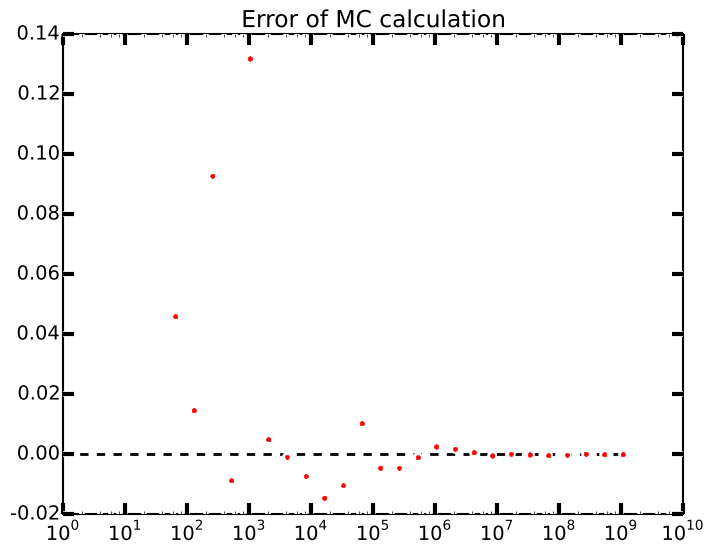

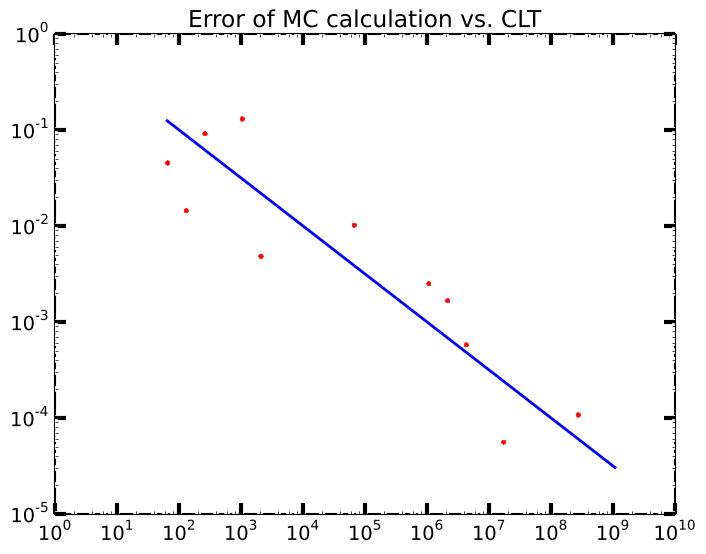

In [77]:
using PyPlot
xkcd(false)
show()
zx = [1, maximum(n_pts)]
zy = [0, 0]
semilogx(zx, zy ,"k--", n_pts, errors, ".r" )
title("Error of MC calculation")
show()

exp_acc = 1./ √(n_pts)

loglog(n_pts, exp_acc, abs(errors'), ".r")
title("Error of MC calculation vs. CLT")
show()
;

It takes us ~15 sec. to estimate $\pi$ on a billion points. However, this used only one core on the machine.  What if we want to use more?  

## Using more than one process

If you're starting up Julia in a terminal, you can use
```
julia -n 4
```
To indicate that 4 processes are available.  If you're using a IJulia notebook, you can add processes with `addprocs()`:

In [2]:
@show nprocs()
addprocs(3)
@show nprocs()

nprocs() = 1
nprocs() = 4

4

(my machine has 4 cores).  Now, Julia will know that it can use up to 4 separate processes, but when you're writing code, you you need to explicitly use them.

In [5]:
m = @spawn randn(2,2)

RemoteRef{Channel{Any}}(3,1,5)

In [6]:
fetch(m)

2x2 Array{Float64,2}:
  0.0762004  -0.524689
 -1.07066    -0.375091

You need to make sure that all processes have access to functions that you define.  In order to define a function on all processes use the `@everywhere` macro

In [14]:
function sum_test(a, b)
    a + b
end

sum_test (generic function with 1 method)

In [15]:
m = @spawn sum_test(1,2)

RemoteRef{Channel{Any}}(4,1,16)

In [16]:
fetch(m)

LoadError: LoadError: On worker 4:
function sum_test not defined on process 4
 in error at ./error.jl:21
 in anonymous at serialize.jl:522
 in anonymous at multi.jl:1325
 in anonymous at multi.jl:889
 in run_work_thunk at multi.jl:645
 in run_work_thunk at multi.jl:654
 in anonymous at task.jl:58
while loading In[16], in expression starting on line 1

In [18]:
@everywhere function sum_test(a, b)
    a + b
end

In [19]:
m = @spawn sum_test(1,2)
fetch(m)

3

If you're loading modules, `using` will load them on all processes, but `include()` will not.

In [20]:
using Distributions
d = @spawn Exponential()

INFO: Recompiling stale cache file /home/brad/.julia/lib/v0.4/StatsFuns.ji for module StatsFuns.
INFO: Recompiling stale cache file /home/brad/.julia/lib/v0.4/Distributions.ji for module Distributions.
INFO: Recompiling stale cache file /home/brad/.julia/lib/v0.4/ArrayViews.ji for module ArrayViews.
INFO: Recompiling stale cache file /home/brad/.julia/lib/v0.4/PDMats.ji for module PDMats.
INFO: Recompiling stale cache file /home/brad/.julia/lib/v0.4/StatsBase.ji for module StatsBase.


RemoteRef{Channel{Any}}(4,1,31)

In [23]:
d2 = fetch(d)
rand(d2)

2.035058308287351

You can control which process is used with `@spawnat`

In [24]:
p = @spawnat 2 1+1

RemoteRef{Channel{Any}}(2,1,35)

In [25]:
fetch(p)

2

The spawn/fetch commands are great for spinning off function evaluations.  If you want something that looks like a parallel for-loop, you can use the `@parallel` macro.  Note that this example does something like a MPI gather. (example from http://docs.julialang.org/en/release-0.4/manual/parallel-computing/)

In [26]:
nheads = @parallel (+) for i=1:200000000
  Int(rand(Bool))
end

99989664

When you use a parallel for-loop, you should make sure that the inner contents of the loop are independent of each other, since you aren't controlling evaluation order, or which process is doing what.  Note that every process also uses its own copy of data, so something like the following will not work like you might wish it to.

In [30]:
a = rand(100)
@parallel for i = 1:100
    a[i] = 1
end
@show a
;

a = [0.7308029549201371,0.22132089690702306,0.3337544224614186,0.9254368483783291,0.1669542492103162,0.9349365606279181,0.6262201712229769,0.5871079046763812,0.8607788989475171,0.11848350134950181,0.2437479966442826,0.9824324791304091,0.67130901513984,0.1292576083007242,0.26944806101982377,0.8160784008218025,0.9999182203979717,0.12470734706982167,0.17271856572330635,0.0994972052248424,0.43136435678552365,0.06171188199247979,0.3517279626822578,0.07191346660778009,0.5836717277914143,0.1055920690920733,0.9110948960947607,0.24629990638076626,0.25989023832483515,0.7780371028749449,0.611312169497604,0.8770708622388326,0.8194546795319884,0.9930064871315667,0.8723666271152086,0.26024261929656745,0.5203701865781956,0.7925183340011555,0.06689996210487759,0.6188103189589964,0.42751398169815613,0.5259373478142637,0.5577535282163189,0.653652554878984,0.13720740567964196,0.7066430312813139,0.13745322914418545,0.20975996765391303,0.36668635293183893,0.7669484789708292,0.20554795481492882,0.4858809510

If you want a distributed array, you can use the [DistributedArrays](https://github.com/JuliaParallel/DistributedArrays.jl) package.

## Exercise 1

* Modify the Monte Carlo calculation of $\pi$ above to use more than one process. (There's more than one way to do this!)
* How fast is your modified version compared to the single process version?

# Distributed Arrays

# Using Julia with MPI

# Distributed Linear Algebra with Elemental